# AIAIART #6 - Transformers and VQ-GAN revisited

The original DALL-E system was announced at the same time as CLIP, and was truly incredible at the time. A baby radish in a tutu holding an umbrella - what a time to be alive! 

The model was never released, but it (and CLIP, which they used to rank the DALL-E outputs and pick the best) did inspire a huge amount of creativity in the open source communities as we sought to replicate this new magic.

Images from [the original announcement](https://openai.com/blog/dall-e/):

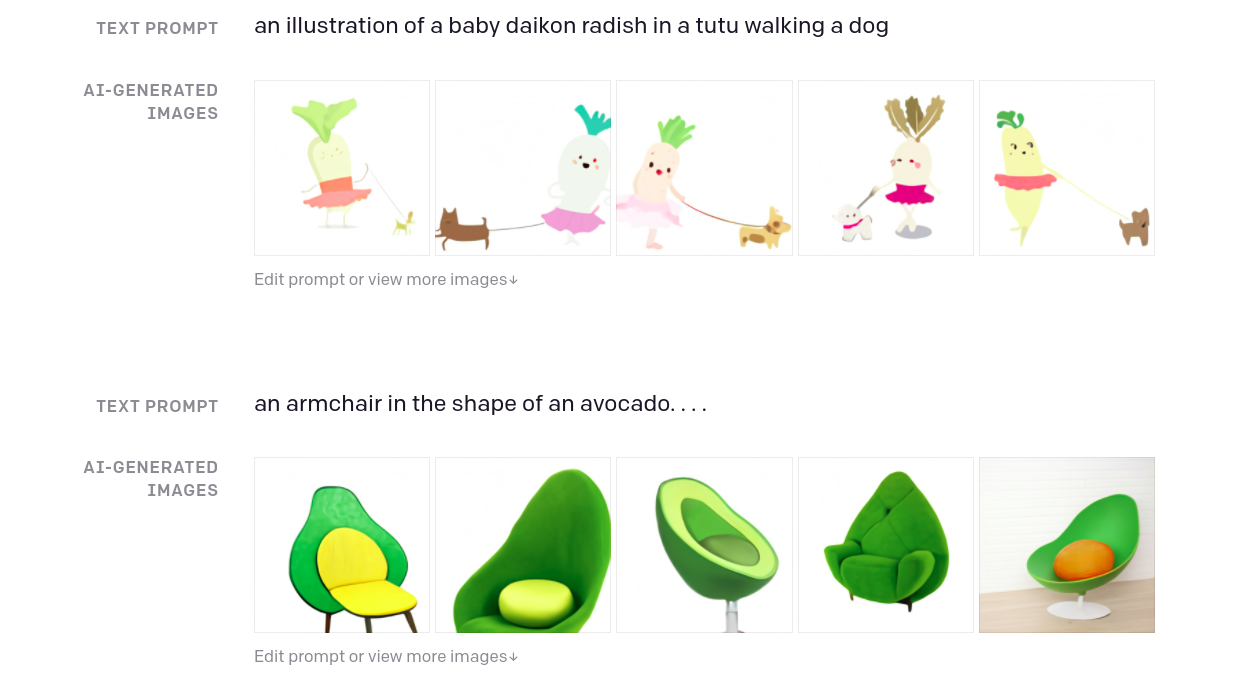

Fast forward to today, and there is an open-source dalle-mini that you can play with (https://huggingface.co/spaces/dalle-mini/dalle-mini, example output pictured below) and a much larger 2.6B parameter model currently training! (Live [W&B link](https://wandb.ai/dalle-mini/dalle-mini/runs/3bhv6pv6))

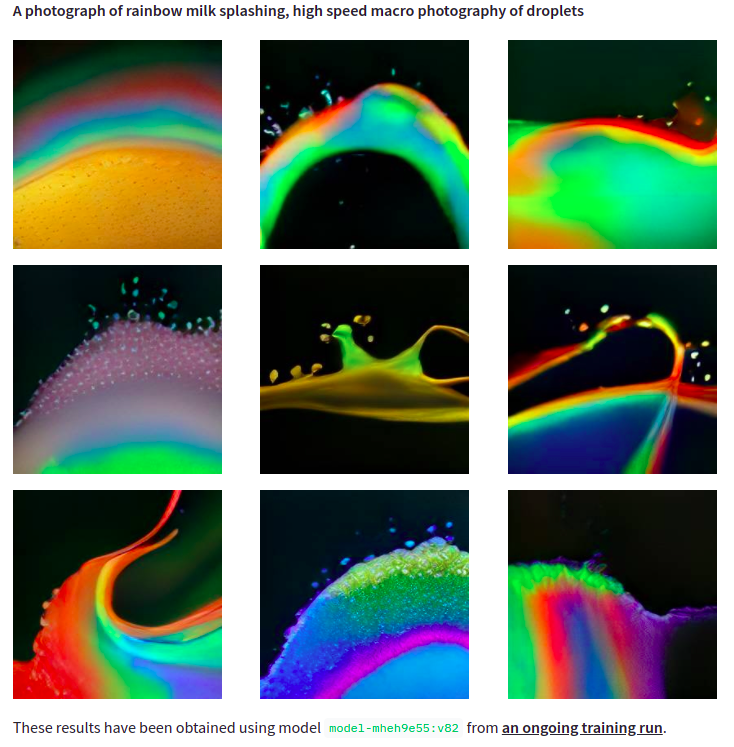

While in some ways these models are a little behind the current state-of-the-art diffusion models, it's still worth taking a closer look into what makes them tick and why we might not want to be too dismissive of these types of models even if they've recently had their limelight stolen.

In [1]:
#@title Lesson Video
import IPython.display as ipd
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MjoR4GAMjzI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

# Setup

In [ ]:
!pip install datasets &>> install.log

In [ ]:
!git clone https://github.com/karpathy/minGPT &>> install.log

In [ ]:
# Download the training data for our text transformer
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2022-04-16 04:40:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2022-04-16 04:40:07 (113 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
import sys
sys.path.append('minGPT')
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig
from mingpt.utils import sample

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# # make deterministic
# from mingpt.utils import set_seed
# set_seed(42)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Section 1: Sequence modelling with transformers

![transformers gif](https://media3.giphy.com/media/3ofT5Pg8rlbuo4Q3GE/200.gif)

Today is going to be all about modelling **sequences**. It's a complex topic, but we're going to try and get a good intuition for what is going on without getting too stuck in the weeds or different implementations or approaches. If you'd like to go deeper, here are some resources you may find helpful:

- ['The Illustrated Transformer'](https://jalammar.github.io/illustrated-transformer/) and the follow-on ['The Illustrated GPT-2'](https://jalammar.github.io/illustrated-gpt2/) are excellent resources for getting a better mental picture of things like self-attention. ['The Annotated GPT-2'](https://amaarora.github.io/2020/02/18/annotatedGPT2.html) is similar with a more code-focused approach.
- The [Neuromatch content for transformers](https://deeplearning.neuromatch.io/tutorials/W2D4_AttentionAndTransformers/student/W2D4_Tutorial1.html) as well as the preceeding [lesson on RNNs](https://deeplearning.neuromatch.io/tutorials/W2D3_ModernRecurrentNeuralNetworks/student/W2D3_Tutorial1.html) are excellent in-depth tutorials that will get you coding up specific parts of the models yourself and interrogating what is happening at a very low level.
- The [fastai course](course.fast.ai) and [their NLP course from 2019](https://www.fast.ai/2019/07/08/fastai-nlp/) are also great if you want to learn more, although they slightly pre-date the modern transformer explosion.
- Some of the people at HuggingFace wrote [a book](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246) on Natural Language Processing with Transformers, which I have not read but is apparently excellent. From what I know of the authors past work it should be a delightful read.

A lot of these models were initially made for natural language processing, but have since found applications in many ways. A sentence beig a sequence of words is not too different from a protein being a sequence of amino acids, or a musical piece being a sequence of notes. For this course we're interested in whether we can apply these ideas to images! But first, let's explore a classic sequence modelling task by trying to train a model to predict the next letter in a piece of text.

## 1.1: Generating Shakespeare

![calculon the acting robot](https://comb.io/x5hIpw.gif)

The model we're going to train in this section is a type of language model. Given a sequence of words or letters (the generic term would be 'tokens'), it outputs probabilities for what the next word could be.

We can use such a model to generate new text like so:
- Feed in a starting sequence - for example, 'This cat is eating '
- Pick the next token based on what the model thinks is likely to come next. In this example, that could be 'a'.
- Add this to what we started with, and feed the result back through the model again. So the model now sees 'This cat is eating a ' and might then predict 'mouse'. 
- Repeat this process. This is called an 'autoregressive' model in that it uses it's past predictions to make new ones. 

This first example is based on one of the demos provided with Andrej Karpathy's excellent [minGPT library](https://github.com/karpathy/minGPT) which we'll use throughout this lesson.

Step one is setting up a dataset. We'll use individual characters as our tokens to keep things simple, but bear in mind that modern models have a much larger vocabulary and work with actual words or sub-words instead. Our model's input ('x') will be `block_size` tokens, and the desired output ('y') will be a shifted version one token along. That is, for block_size 10, x might be 'have a dre' and y would be 'ave a drea'. Setting it up this way helps keep training efficient for reasons that are explained by Karpathy in [the full example](https://github.com/karpathy/minGPT/blob/master/play_char.ipynb).

Feel free to dig into the dataset to get a feel for what's going on:


In [ ]:
#@title CharDataset (from minGPT examples)
class CharDataset(Dataset):
  def __init__(self, data, block_size):
    chars = sorted(list(set(data))) # All the letters present in the data
    data_size, vocab_size = len(data), len(chars)
    print('data has %d characters, %d unique.' % (data_size, vocab_size))

    # Set up a way to go from text -> numeric representations and back
    self.stoi = { ch:i for i,ch in enumerate(chars) }
    self.itos = { i:ch for i,ch in enumerate(chars) }

    # Store some key variables
    self.block_size = block_size
    self.vocab_size = vocab_size
    self.data = data
    
  def __len__(self):
    # In this case just the length of the full text - block_size
    return len(self.data) - self.block_size

  def __getitem__(self, idx):
    # grab a chunk of (block_size + 1) characters from the data
    chunk = self.data[idx:idx + self.block_size + 1]
    # encode every character to an integer
    dix = [self.stoi[s] for s in chunk]
    # The goal is autoregression, y is 1 token 'ahead' of x
    x = torch.tensor(dix[:-1], dtype=torch.long)
    y = torch.tensor(dix[1:], dtype=torch.long)
    return x, y

We can choose how much text we want the model to be able to work with at a time. A longer context might mean better performance and the ability to keep track of more complex scenarios, at the expense of computational complexity. Feel free to experiment.

In [ ]:
block_size = 128 # spatial extent of the model for its context

In [ ]:
# This text file was downloaded during the setup - try replacing it with your own!
text = open('input.txt', 'r').read()
train_dataset = CharDataset(text, block_size)

data has 1115394 characters, 65 unique.


In [ ]:
train_dataset[0] # Notice y is offset by 1 from x. 

(tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
         53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
          1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
         57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
          6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
         58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
          1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
         53,  1]),
 tensor([47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53,
         56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,  1,
         44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1, 57,
         54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,  6,
          1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47, 58,
         

With the data ready, we can create a model and train it using the minGPT library. This takes a while, so you can also skip the next few cells and run 'loading a trained model from the hub' to download a model I trained while setting up this lesson.

In [ ]:
# Create a model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

04/15/2022 09:55:54 - INFO - mingpt.model -   number of parameters: 2.535219e+07


In [ ]:
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=1, batch_size=256, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size,
                      num_workers=4)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

In [ ]:
#@title (saving model to hub)
# !git config --global user.name "johnowhitaker"
# !git config --global user.email "johnowhitaker@gmail.com"
# !huggingface-cli login
# !apt install git-lfs
# from huggingface_hub import PyTorchModelHubMixin
# class minGPTWithPyTorchModelHubMixin(model.__class__, PyTorchModelHubMixin):
#     pass
# model.__class__ = minGPTWithPyTorchModelHubMixin
# model.push_to_hub('johnowhitaker/mingpt-char-shakespeare')

In [ ]:
#@title loading a trained model
from mingpt.model import GPT, GPTConfig
from huggingface_hub import PyTorchModelHubMixin
class minGPTWithPyTorchModelHubMixin(model.__class__, PyTorchModelHubMixin):
    pass
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)
model.__class__ = minGPTWithPyTorchModelHubMixin
model = model.from_pretrained('johnowhitaker/mingpt-char-shakespeare', config=mconf).to(device)

04/15/2022 09:57:55 - INFO - mingpt.model -   number of parameters: 2.535219e+07
config.json not found in HuggingFace Hub
04/15/2022 09:57:55 - WARNING - huggingface_hub.hub_mixin -   config.json not found in HuggingFace Hub


Downloading:   0%|          | 0.00/102M [00:00<?, ?B/s]

04/15/2022 09:58:04 - INFO - mingpt.model -   number of parameters: 2.535219e+07


To generate text with this model, we pass in the 'context' and then use the sample function from minGPT to carry on from there. We could always take the most likely next word, but we can also consider the `top_k` possible words with the highest predicted likelihoods and choose from them based on the `temperature` parameter, where a higher tempreature means a higher chance of getting a word that isn't just the top prediciton. 

In [ ]:
# Sampling from the model:
context = "Oh no! Please, "
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 500, temperature=1.0, sample=True, top_k=10)[0]
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

Oh no! Please, I come,
What durst you to save her life?

PETRUCHIO:
Petruchio, shall I then come roundly to thee
And wish thee to a shrewd ill-favour'd wife?
Thou'ldst thank me but a little for my counsel:
And yet I'll promise thee she's called so.

HENRY BOLINGBROKE:
Nay, stand all apart.

KING RICHARD II:
Dorset, embrace him; Hastings, love lord marquess.

DORSET:
This interchange of love, I here protest,
Upon my part shall be unviolable.

HASTINGS:
And so swear I, my lord

KING EDWARD IV:
Now, princely Buck


Perhaps it is not quite as good as the bard himself, but it does show the power of these models. Remember, we feed in the text letter by letter and in a relatively short time it has learnt to produce output that is at least a lot better than random gibberish! A larger model, a better tokenizer and a LOT more paramemers and training time => GPT-3 et al which can do some absolutely remarkable things.

**Side note**: This model has been trained to predict the next token in a sequence, and this is useful for generating new text. But to do this task well, it has had to 'learn' a lot about what a sentence **means** and how that might affect what happens next. In doing so, it has learnt to create very meaningful representations from text. We can take advantage of these learned representations for many other tasks, such as text classification. You'll see this general approach everywhere in NLP and elsewhere: train an autoregressive model on a huge aount of unlabelled data and the fine-tune it on a new task such as sequence classificaiton with a relatively small amount of labelled data. 

## 1.2 What is this magical model anyway?

The transformer architecture was first proposed in [Attention Is All You Need](https://arxiv.org/abs/1706.03762) in 2017. Their architecture consisted of stacks of identical encoder and decoder blocks, like this:

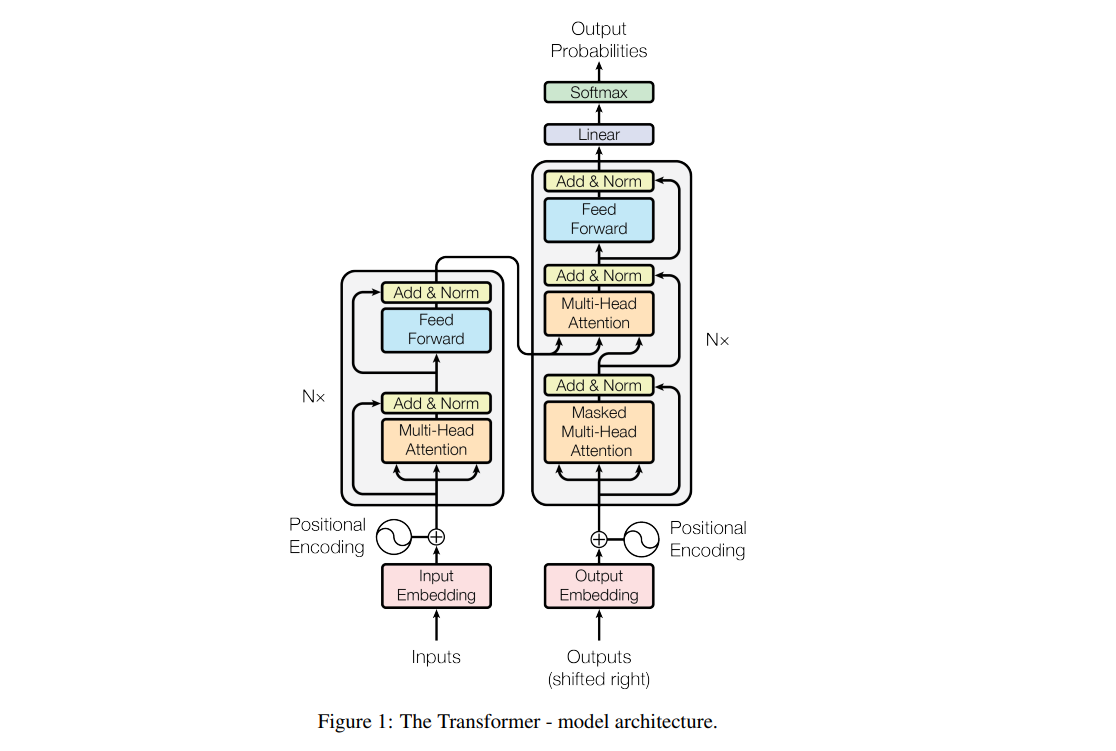

This works pretty well, but since then we've seen a rise in encoder-only models (like BERT) or decoder-only models (like GPT) which simplify the architecture further. Here's a representation of the architecture behind GPT-2, which consists of a stack of 12, 24, 36 or 48 decoder blocks (for the small, medium, large and extra-large versions respectively).

![GPT architecture](https://jalammar.github.io/images/gpt2/gpt2-self-attention-example-2.png)

Let's look at some key ideas here

1) Embeddings

These models have a vocabulary size, typically quite large (eg 50,000 words). We want to turn a word or other token into a vector that we can operate on. To do this, a (learned) matric maps each unique token onto an embedding, whose size can be adjusted depending on how big of a model you want. 

The neat thing with learnt embeddings is that even before we hit any fancy transformer blocks we can capture some useful semantic meaning. The embedding for the word 'dog' might be similar to that of 'puppy', and in fact there is a whole field of research around the relationships between words in this kind of word-to-vector system (see word2vec).

2) Positional Encodings

We can give the model more context be feeding in not just the embedding of a word but some representation of where it occurs within the sequence. There has been some recent work showing that transformers can do OK without this, but it's a useful construct and might be especially handy for our work with images. The simplest form of position encoding would be a single value running from 0 (start of the sequence) to 1 (final position). In practice we usually see more complex sinusoidal encodings or other fancy tricks to give the model more to work with.

3) Attention 

This is the key bit. Attention gives the model the ability to 'focus' on other parts of the sequence which may be relevant. Notice in the diagram above, we're running 'it' through the stack but the self-attention layer then attends to the relevant 'a robot' part of the sequence which is vital context.

How this works can seem a little mysterious, but the core is this: the model learns some weight matrices (WQ, WK, WV) which are used to compute queries, keys and values as inputs are fed into the attention layer. With these, we can get 'scores' for how well different values (from past tokens) match the query derived from the cirrent token. Higher scores for certain values mean those will contribute more to the final output. 


4) Multi-headed masked self attention

Multi-headed: We can split things between multiple 'attention heads' with a littel reshaping and splitting. The theory here is that this gives more space for different parts of the model to focus on different things. A rough mental analogy might be multiple filters in a CNN.

Masked attention: when doing the auto-regressive task, we can't look at an entire sequence, only the tokens that come before the one we're currently looking at. So we mask out any attention that would otherwise let the model 'look forward in time' i.e. peek ahead at upcoming tokens. 

5) Everything is a weight matrix

All these operations seem quite complex, but it's all matrix maths. Input token multiplied with WQ gives the query vector, etc etc. So we're talking about these abstractions like keys and values, but really it's all just matricies being manipulated together and what happens depends on some key weights (aka parameters). And from last week we know how to optimise a set of parameters to achieve some goal!


So that's our 'transformers in a nutshell' summary. If your eyes are glazing over, don't stress! Just remember that these models take in a sequence of tokens and try to learn how to predict what is going to come next. And to do so, they use a whole bunch of parameters in some clever ways to try and extract information not just from a token individually but from the context of the sequence around it. By scaling up the number of parameters (more heads, more layers in the stack, larger embedding size...) we can get very large and very powerful models able to learn a shocking amount from the data we feed through them during training.

And with that concept in our heads, let's go back to our earlier question: how do these cope with images?


# Section 2: VQGAN revisited - encoding images as sequences

So, we've seen how transformer models can be used to model sequences of tokens... how is that useful to us?

The first idea that pops into your head might be that we can represent an image as a sequence of tokens, where each token is a single pixel. This has been tried with mixed results - images can have millions of pixels which means computationally it get's hard to take this approach very far. 

To get around this, we need some sort of compressed representation - a way of encoding a whole patch of an image with a single token, based on a visual 'vocabulary' of possible patches. Sound familiar? That's right - we saw something like this when we looked at VQ-GAN:

![taming paper header](https://github.com/CompVis/taming-transformers/raw/master/assets/teaser.png)

Now there are variations on this approach, and so if you look at the original dall-e paper or read up on model vision transformers you'll see the different approaches. But the one from the ['Taming Transformers for High Resolution Image Synthesis' paper](https://arxiv.org/abs/2012.09841)  illustrated above is a fairly representative one which we can use to explore the idea. 

Since the next section is going to take a while to run, let's set it going and then discuss what's happening before diving into the paper for a few more details. If you're just reading this and not following along with the lesson video, give the paper a skim and see if you can figure out how they work their magic :)

## Additional Setup

Downloads a pretrained VQGAN model etc - run this while we talk.

In [ ]:
#@title Download VQGAN + additional setup

# This is a little messy, but the goal here
# is just to set things up for the coming demo.
# Chat to me if you want to try something like this
# 'for real' since there are many things worth changing.

# Downloading a pre-trained VQGAN model
print('Downloading VQGAN model weights')
!curl -L 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_im1024.ckpt
!curl -L 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_im1024.yaml 
#Install VQGAN requirements
print('Installing requirements')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops omegaconf pytorch_lightning &> /dev/null

# VQGAN setup
import sys, einops, torch
sys.path.append('./taming-transformers')
from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
from PIL import Image
from matplotlib import pyplot as plt


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

print('Loading VQGAN model')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vqgan_model = load_vqgan_model('vqgan_im1024.yaml', 'vqgan_im1024.ckpt').to(device)  


print('Dataset Prep')
!pip install openimages
!wget https://storage.googleapis.com/localized-narratives/annotations/open_images_validation_captions.jsonl

import json

with open('/content/open_images_validation_captions.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list[:5]:
    result = json.loads(json_str)
    # print(f"result: {result}")
    # print(isinstance(result, dict))

import urllib3
import boto3
import botocore
import concurrent.futures
import os
from tqdm.notebook import tqdm

def _download_single_image(arguments):
    """
    Downloads and saves an image file from the OpenImages dataset.
    :param arguments: dictionary containing the following arguments:
        "s3_client": an S3 client object
        "image_file_object_path": the S3 object path corresponding to the image
            file to be downloaded
        "dest_file_path": destination directory where the image file should be
            written
    """
    if os.path.exists(arguments["dest_file_path"]):
        return

    try:
        with open(arguments["dest_file_path"], "wb") as dest_file:
            arguments["s3_client"].download_fileobj(
                "open-images-dataset",
                arguments["image_file_object_path"],
                dest_file,
            )

    except urllib3.exceptions.ProtocolError as error:
        _logger.warning(
            f"Unable to download image {arguments['image_file_object_path']} -- skipping",
            error,
        )


def download_images_by_id(image_ids,section, images_directory):
    """
    Downloads a collection of images from OpenImages dataset.
    :param image_ids: list of image IDs to download
    :param section: split section (train, validation, or test) where the image
        should be found
    :param images_directory: destination directory where the image files are to
        be written
    """

    # we'll download the images from AWS S3 so we'll need a boto S3 client
    s3_client = boto3.client(
        's3',
        config=botocore.config.Config(signature_version=botocore.UNSIGNED),
    )

    # create an iterable list of function arguments
    # that we'll map to the download function
    download_args_list = []
    for image_id in image_ids:
        image_file_name = image_id + ".jpg"
        download_args = {
            "s3_client": s3_client,
            "image_file_object_path": section + "/" + image_file_name,
            "dest_file_path": os.path.join(images_directory, image_file_name),
        }
        download_args_list.append(download_args)

    # use a ThreadPoolExecutor to download the images in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:

        # use the executor to map the download function to the iterable of arguments
        list(tqdm(executor.map(_download_single_image, download_args_list),
                  total=len(download_args_list), desc="Downloading images"))

!mkdir -p ims

def get_openimages(n_images=2000):
  print('Downloading images')
  download_images_by_id([json.loads(s)['image_id'] for s in json_list[:n_images]], 'validation', 'ims/')
  data = [json.loads(s) for s in json_list[:n_images]]
  return data

In [ ]:
type(vqgan_model) # Our vqgan model is loaded

taming.models.vqgan.VQModel

In [ ]:
data = get_openimages(n_images=5000) # 2k for quick demo, 20k for a better attempt at training

In [ ]:
len(data), data[0] # Roughly what our data looks like

(5000,
 {'annotator_id': 131,
  'caption': 'In this image I can see a man in red wearing orange cap, making food on a stove, and on the right there is a white knife in a container, and there are also other chef here, and there are so many people here, and objects here, and in the background there is a white car, a building here, posters here, and trees.',
  'dataset_id': 'open_image',
  'image_id': 'd3d10cc7a6b1bbea'})

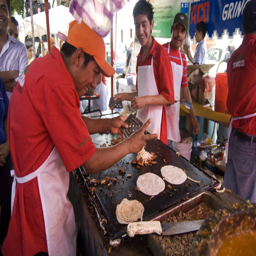

In [ ]:
Image.open('ims/d3d10cc7a6b1bbea.jpg').resize((256, 256)) # View the image

## Getting our dataset ready

We want to convert these images to a sequence of tokens with VQGAN, and set up a dataset similar to our shakespeare dataset above. I chose here to encode all the images when we initialize the dataset - a more scalable option for larger datasets would be to load the images and encode them when needed, or encode them in batches and save the encodings to disk to be loaded when needed. 

In [ ]:
#@title PatchDataset Definition
from torch.utils.data import Dataset
class PatchDataset(Dataset):

    def __init__(self, data, block_size=255):
        # Iterate through images getting VQGAN tokens from 256px versions and CLIP embeddings
        self.ims = [] # Images as encoded by VQGAN
        for im in data:
          fn = 'ims/'+im['image_id']+'.jpg'
          pil_im = Image.open(fn).convert('RGB').resize((256, 256))
          im_tensor = torch.tensor(np.array(pil_im)).permute(2, 0, 1) / 255
          z, a, b = vqgan_model.encode(im_tensor.to(device).unsqueeze(0) * 2 - 1)
          idx = b[-1] # The codebook entries (16x16 tokens)
          self.ims.append(idx.detach().cpu().numpy())

        # A better approach would be to use range(1024) here
        chars = sorted(list(set(list(np.concatenate(self.ims))))) # range(1024)
        data_size, vocab_size = len(data), len(chars)

        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.ims[idx]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


In [ ]:
# Create the dataset and examine the first x, y pair
dset = PatchDataset(data)# Takes a while  since it encodes each image with VQGAN. 5 sec per 100 ims.
x, y = dset[0]
x.shape, y.shape, x[-3:], y[-3:] # Y is x offset by 1.

data has 5000 characters, 452 unique.


(torch.Size([255]),
 torch.Size([255]),
 tensor([175, 288, 396]),
 tensor([288, 396,  93]))

We have the image as a sequence of tokens. So we can now feed it to effectively the same model we used for the shakespeare stuff:

In [ ]:
from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(dset.vocab_size, dset.block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

block_size=255

from mingpt.trainer import Trainer, TrainerConfig
import torch

# initialize a trainer instance and kick off training
# increase max_epochs to train more, drop batch_size if you're getting memory issues
tconf = TrainerConfig(max_epochs=3, batch_size=64, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(dset)*block_size,
                      num_workers=4)
trainer = Trainer(model, dset, None, tconf)
trainer.train()

04/16/2022 05:15:54 - INFO - mingpt.model -   number of parameters: 2.581350e+07
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch 1 iter 74: train loss 5.90673. lr 3.020025e-04: 100%|██████████| 75/75 [01:08<00:00,  1.09it/s]
epoch 2 iter 74: train loss 5.80702. lr 6.000000e-05: 100%|██████████| 75/75 [01:09<00:00,  1.08it/s]
epoch 3 iter 74: train loss 5.80560. lr 3.020025e-04: 100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Now we can sample from the model, as before. Here we'll feed in half of an image as the context, and have the model try to complete the image:

04/16/2022 05:19:24 - WARNING - matplotlib.image -   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


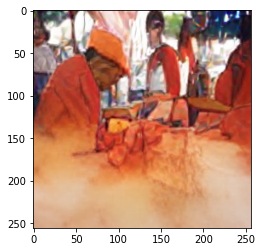

In [ ]:
context = dset.ims[0][:128] # half of the first image in the dataset
x = torch.tensor([dset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 128, temperature=1., sample=True, top_k=100)[0]
completion = [dset.itos[int(i)] for i in y]
ccc = completion[-256:]
zs = vqgan_model.quantize.get_codebook_entry(torch.tensor(ccc).to(device), (1, 16, 16, 256))
plt.imshow(vqgan_model.decode(zs).add(1).div(2).cpu().squeeze().permute(1, 2, 0))

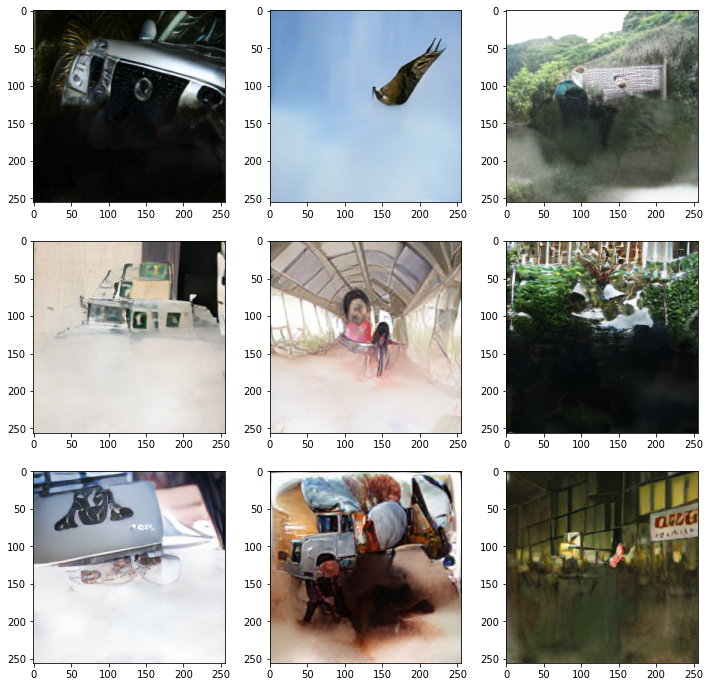

In [ ]:
# @title plotting a few more:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
  context = dset.ims[i+60][:128] # random image, half only
  x = torch.tensor([dset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
  y = sample(model, x, 128, temperature=1., sample=True, top_k=100)[0]
  completion = [dset.itos[int(i)] for i in y]
  ccc = completion[-256:]
  zs = vqgan_model.quantize.get_codebook_entry(torch.tensor(ccc).to(device), (1, 16, 16, 256))
  axs[i%3, i//3].imshow(vqgan_model.decode(zs).add(1).div(2).cpu().squeeze().permute(1, 2, 0).clip(0, 1))

We're training with only a few thousand images here, so the results are not particularly impressive. And the vqgan model used has a fairly small (1024) codebook which limits how well we can reconstruct images. Just to re-iterate, this is just a demo :)

# Section 3: Training our own DALL-E micro model

In this section we'll put together the pieces above and attempt to make our own text-to-image system. But first, some highly cherry-picked outputs:

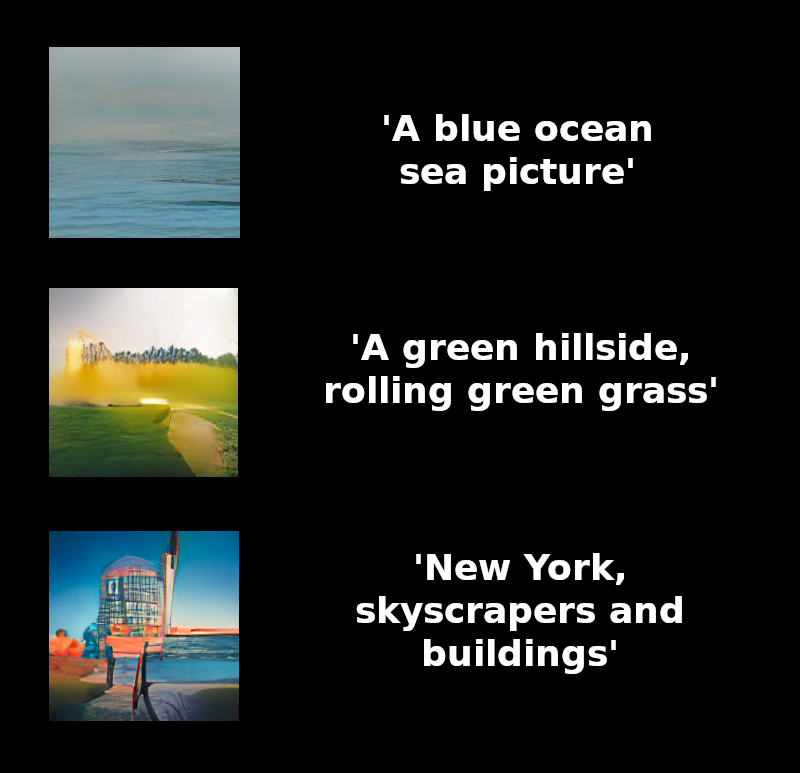

How are we going to achieve this magic? Easy! We just combine the two previous examples. We'll encode both text and image patches together, and the model will see the tokens representing the caption followed by the image. As before, it will learn to predict the next token in a given sequence. Then when we want to generate new images, we'll feed in just the text as our starting context and have the model proceed from there!

We're going to gloss over specifics of how exactly we set up the dataset and so on since this is just a demo, but feel free to dig into the code. 

It's also going to take more than a few minutes to train a model that works at all, so while you can try to run the training code with the few thousand images in the demo dataset I also show how to load up a model I trained with about $10 worth of GPU time on a dataset of hundreds of thousands of images. Try it out and then never use it again because something like dalle-mini is better in every way! Again, this is all just trying to demystify these models by making simple demo versions.

In [ ]:
# @title modified dataset now includes text tokens before the image ones
from torch.utils.data import Dataset
import numpy as np

max_text_length = 128
vocab = 'abcdefghijklmnopqrstuvwxzy '

def encode_char(c):
  if c in vocab:
    return vocab.index(c)
  return 50 # 'special character'

class PatchDataset(Dataset):

    def __init__(self, image_fns, labels, block_size=255, max_text_length=128):
        # Iterate through images getting VQGAN tokens from 256px versions and CLIP embeddings
        self.ims = [] # Images as encoded by VQGAN
        self.conds = []
        
        for fn, caption in tqdm(zip(image_fns, labels)):
            self.ims.append(fn)
            self.conds.append(caption)

        # 1024 possible VQGAN codes + our text encoding  
        chars = range(1024+53)
        data_size, vocab_size = len(image_fns), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size # + max_text_length << TODO?
        self.vocab_size = vocab_size
    
    def __len__(self):
        return len(self.ims)# was len(self.data) - self.block_size

    def __getitem__(self, idx):
        
        fn = self.ims[idx]
        caption = self.conds[idx]
        
        # Encode the image with vqgan
        pil_im = Image.open(fn).convert('RGB').resize((256, 256))
        im_tensor = torch.tensor(np.array(pil_im)).permute(2, 0, 1) / 255
        with torch.no_grad():
            z, a, b = vqgan_model.encode(im_tensor.to(device).unsqueeze(0) * 2 - 1)
        im_idxs = b[-1] # The codebook entries (16x16 tokens)
        
        # Encode the caption:
        char_idxs = [encode_char(c) for c in caption.lower()[:max_text_length]]
        while len(char_idxs) < max_text_length:
            char_idxs += [51] # A blank token
        # 52 is our 'end of caption' symbol
        char_idxs += [52]
        # At the moment these will clash with tokens fom vqgan so we add 1024
        char_idxs = [c+1024 for c in char_idxs]
        
        # Combine
        dix = [self.stoi[int(s)] for s in char_idxs] # Start with the encoded caption
        dix += [self.stoi[int(s)] for s in im_idxs] # Then the image tokens
        
        # Split into x and y
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [ ]:
# Our new dataset
image_fns = ['ims/'+d['image_id']+'.jpg' for d in data]
labels = [d['caption'] for d in data]
dset = PatchDataset(image_fns, labels, max_text_length=max_text_length)
x, y = dset[0]
x.shape, y.shape, x[-3:], y[-3:] # Y is x offset by 1.

0it [00:00, ?it/s]

data has 5000 characters, 1077 unique.


(torch.Size([384]),
 torch.Size([384]),
 tensor([455, 675, 906]),
 tensor([675, 906, 243]))

In [ ]:
## uncomment to check out the full x
# x # 128 text tokens then the image (missing the last token)

In [ ]:
#@title Create & train the model (optional)
block_size=255+max_text_length+1 # To fit the conditioning in as well
mconf = GPTConfig(dset.vocab_size, block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

# Train
tconf = TrainerConfig(max_epochs=1, batch_size=32, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(dset)*block_size,
                      num_workers=0) # num_workers=0 to avoid some multiprocessing bugs
trainer = Trainer(model, dset, None, tconf)
trainer.train()

04/16/2022 05:24:04 - INFO - mingpt.model -   number of parameters: 2.651955e+07
epoch 1 iter 156: train loss 4.44345. lr 3.012600e-04: 100%|██████████| 157/157 [06:36<00:00,  2.52s/it]


In [ ]:
# You might want to save your trained model:
# torch.save(model.state_dict(),'saved_model.ckpt') # Save model weights

In [ ]:
#@title Download and load a trained model
# Download one I trained for 5 epochs on 200k images from a different dataset:
!wget https://huggingface.co/johnowhitaker/mingpt-vqgan1024/resolve/main/saved_model_5x200ksteps.ckpt
block_size=255+max_text_length+1 # To fit the conditioning in as well
mconf = GPTConfig(dset.vocab_size, block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf).cuda()
model.load_state_dict(torch.load('/content/saved_model_5x200ksteps.ckpt'))

04/16/2022 05:58:12 - INFO - mingpt.model -   number of parameters: 2.651955e+07


<All keys matched successfully>

  0%|          | 0/9 [00:00<?, ?it/s]

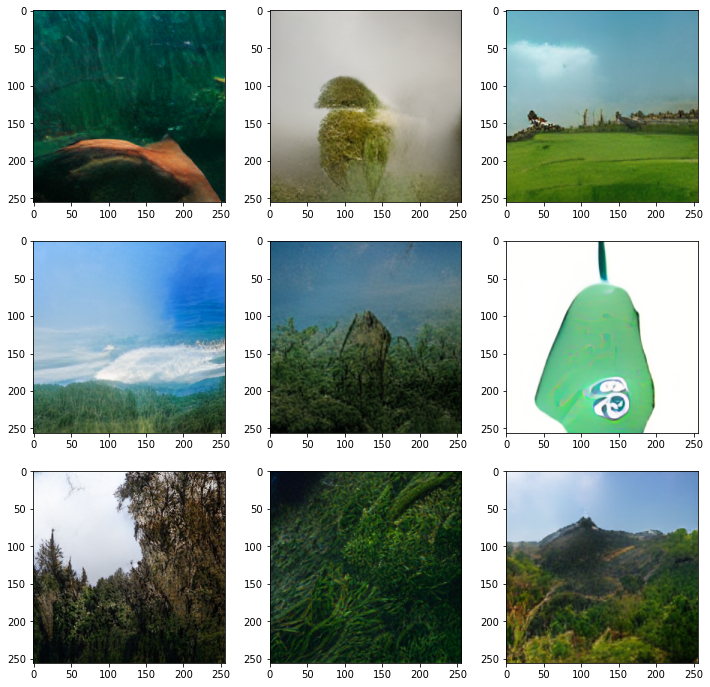

In [ ]:
#@title Generate some images!

prompt = 'A mountain landscape, green hills and a blue sky' #@param
 
# Encode the prompt as we do in the dataset
char_idxs = [encode_char(c) for c in prompt.lower()[:max_text_length]]
while len(char_idxs) < max_text_length:
    char_idxs += [51] # A blank token
char_idxs += [52] # 52 is our 'end of caption' symbol
char_idxs = [c+1024 for c in char_idxs] # As in the dataset

# Plot some example outputs
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in tqdm(range(9)):
    x = torch.tensor([dset.stoi[s] for s in char_idxs], dtype=torch.long)[None,...].to(device)
    y = sample(model, x, 256, temperature=1., sample=True, top_k=200)[0]
    completion = [dset.itos[int(i)] for i in y]
    ccc = completion[-256:]
    ccc = [min(c, 1023) for c in ccc] # Make sure in vqgan range
    with torch.no_grad():
        zs = vqgan_model.quantize.get_codebook_entry(torch.tensor(ccc).to(device), (1, 16, 16, 256))
        axs[i%3, i//3].imshow(vqgan_model.decode(zs).add(1).div(2).cpu().squeeze().permute(1, 2, 0).clip(0, 1))

Let's take a moment to appreciate what's going on here! This isn't like our previous experiments where we lean on a model like CLIP that has seen hundreds of millions of images. We're starting FROM SCRATCH learning to model sequences of text and image tokens, and ending up with a model that can take a description of what you want and attempt an image matching that description. It's not very good, but the fact that it works at all is a little mind-blowing! What a time to be alive.

## 3.1 Aside: Experiment tracking

Some charts from my W&B project for the above model:

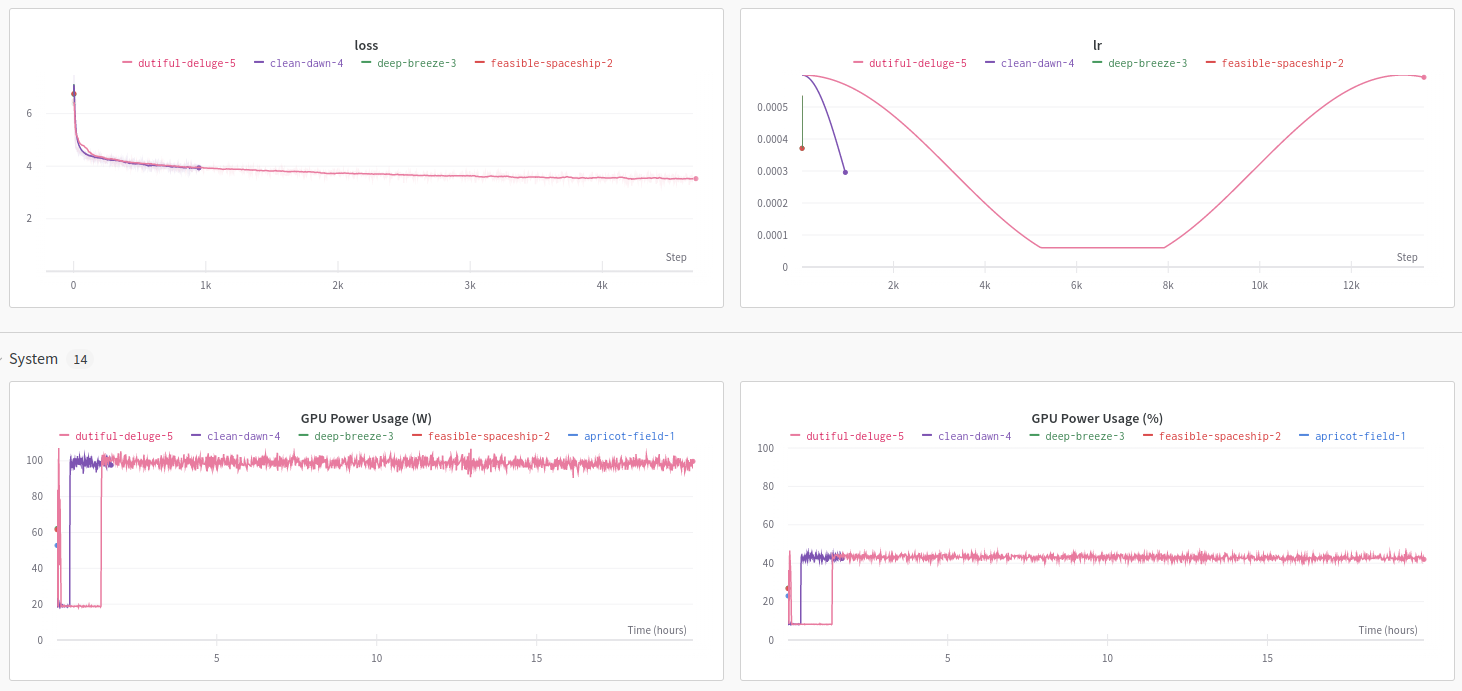

We're getting into the realm of models that are a little large to train in a few minutes on Google Colab. The dall-e mini runs can be weeks long, and even my overnight training run for the demo model above was long enough that it was worth doing a few things to make life easier:
- Notebooks are great for experimentation but sometimes it's worth formalizing things into a script, complete with logging and extra debugging output.
- Saving checkpoints while training means a crash might not result in the entire run being wasted
- Platforms like vast.ai, paperspace, GCP, AWS etc let you rent a beefy computer for as long as you need it.
- A tool like Weights and Biases lets you monitor vital stats to check on progress, see resource utilization, compare runs with different parameters, see demo outputs and track hyperparameters used. [Here's the project for the model above](https://wandb.ai/johnowhitaker/img_gpt) which is about as simple as it gets. Next week we'll see some fancier tracking with this tool. Highy recommend checking them out if you're looking to get more serious with training models in a reproducible way.


# Section 4: So what have we learnt?

Let's take a step back and try to recap some of the key takeaways in this lesson:

- Modern transformer models are able to learn complex patterns in sequences of data
- We can represent both text and images as sequences of tokens, and for both of these (separately or together) transformers can learn how to continue a sequence given some starting tokens
- If we feed in a sequence containing some 'conditioning' tokens like a text prompt or a mask image, a transformer with the right training can then output a sequence corresponding to our desired output. 
- This all seems a little more complex than any models we've trained previously, but ultimately we're still just optimising a bunch of parameters to minimise some loss. This is something you can do!

I hope this notebook has given you a bit of a better grasp of what is happening behind the scenes of these transformer-based approaches. With your new-found knowledge, I recommend having a play with the dalle-mini demos and running the example colab from the 'taming transformers' paper to generate some pretty landscapes. Dig in to their code and see if you can puzzle out what is happening. 

That's it for this lesson! See you in the next one where we'll finally dive into diffusion models :)

In [ ]:
# PS: If you need to free up some GPU ram, run:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()